In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

tf.random.set_seed(42)
np.random.seed(42)

igneous_rock_properties = {
    "Granite":     {"velocity": (5.5, 0.1), "amplitude": (0.57, 0.02), "duration": (240, 10), "frequency_Hz": (40, 3)},
    "Basalt":      {"velocity": (5.6, 0.1), "amplitude": (0.60, 0.02), "duration": (225, 10), "frequency_Hz": (42, 2)},
    "Diorite":     {"velocity": (5.4, 0.1), "amplitude": (0.59, 0.02), "duration": (230, 10), "frequency_Hz": (39, 3)},
    "Andesite":    {"velocity": (5.45, 0.1), "amplitude": (0.58, 0.02), "duration": (235, 10), "frequency_Hz": (38, 2)},
    "Rhyolite":    {"velocity": (5.3, 0.1), "amplitude": (0.55, 0.02), "duration": (220, 10), "frequency_Hz": (41, 3)},
    "Obsidian":    {"velocity": (5.2, 0.1), "amplitude": (0.60, 0.02), "duration": (225, 10), "frequency_Hz": (44, 2)},
    "Gabbro":      {"velocity": (5.6, 0.1), "amplitude": (0.61, 0.02), "duration": (235, 10), "frequency_Hz": (40, 3)},
    "Pumice":      {"velocity": (5.1, 0.1), "amplitude": (0.56, 0.02), "duration": (215, 10), "frequency_Hz": (36, 2)}
}

def generate_dataset(props, samples_per_class=800, seed=42):
    """Generate dataset with more samples for better training"""
    np.random.seed(seed)
    data = []

    for rock_type, features in props.items():
        for _ in range(samples_per_class):
            row = {
                "rock_type": rock_type,
                "velocity": np.random.normal(*features["velocity"]),
                "amplitude": np.random.normal(*features["amplitude"]),
                "duration": np.random.normal(*features["duration"]),
                "frequency_Hz": np.random.normal(*features["frequency_Hz"])
            }
            data.append(row)

    df = pd.DataFrame(data)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    return df

df = generate_dataset(igneous_rock_properties)

df['velocity_x_amplitude'] = df['velocity'] * df['amplitude']
df['velocity_squared'] = df['velocity'] ** 2
df['duration_squared'] = df['duration'] ** 2
df['amplitude_duration'] = df['amplitude'] * df['duration']
df['velocity_frequency'] = df['velocity'] * df['frequency_Hz']
df['amplitude_frequency'] = df['amplitude'] * df['frequency_Hz']
df['duration_frequency'] = df['duration'] * df['frequency_Hz']
df['velocity_duration'] = df['velocity'] * df['duration']
df['amplitude_squared'] = df['amplitude'] ** 2
df['frequency_squared'] = df['frequency_Hz'] ** 2
df['velocity_amplitude_ratio'] = df['velocity'] / df['amplitude']
df['duration_frequency_ratio'] = df['duration'] / df['frequency_Hz']
df['velocity_duration_ratio'] = df['velocity'] / df['duration']
df['velocity_cubed'] = df['velocity'] ** 3
df['amplitude_cubed'] = df['amplitude'] ** 3

print(df)

     rock_type  velocity  amplitude    duration  frequency_Hz  \
0      Diorite  5.359520   0.612656  245.973973     40.934069   
1     Andesite  5.487087   0.560173  225.341732     38.473434   
2     Obsidian  5.241652   0.603947  236.280026     46.320496   
3       Gabbro  5.636927   0.586288  226.991591     44.693744   
4      Granite  5.525972   0.551914  246.385925     35.015440   
...        ...       ...        ...         ...           ...   
6395  Rhyolite  5.244487   0.506859  211.857953     39.289774   
6396    Gabbro  5.668919   0.607089  234.181423     40.339062   
6397    Gabbro  5.643008   0.596926  237.230380     40.206793   
6398    Gabbro  5.696670   0.640126  219.519116     38.945549   
6399    Basalt  5.614552   0.587718  226.409827     45.177254   

      velocity_x_amplitude  velocity_squared  duration_squared  \
0                 3.283543         28.724460      60503.195360   
1                 3.073720         30.108121      50778.896312   
2                 3.1

In [2]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['rock_type'])
feature_cols = [
    'velocity', 'amplitude', 'duration', 'frequency_Hz',
    'velocity_x_amplitude', 'velocity_squared', 'duration_squared',
    'amplitude_duration', 'velocity_frequency', 'amplitude_frequency',
    'duration_frequency', 'velocity_duration', 'amplitude_squared',
    'frequency_squared', 'velocity_amplitude_ratio', 'duration_frequency_ratio',
    'velocity_duration_ratio', 'velocity_cubed', 'amplitude_cubed'
]

X = df[feature_cols].values
y = df['label'].values

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [3]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

def create_model(input_dim, num_classes, dropout_rate=0.3):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),

        # First block
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        # Second block
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        # Third block
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate * 0.5),

        # Fourth block
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate * 0.5),

        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_model(X_scaled.shape[1], len(le.classes_))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [4]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=20,
        restore_best_weights=True,
        monitor='val_accuracy',
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.3,
        patience=8,
        min_lr=1e-6,
        monitor='val_accuracy',
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "igneous_model_improved.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,080 (730.78 KB)

 Trainable params: 185,160 (723.28 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [5]:
print("Training improved model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,  # More epochs with early stopping
    batch_size=64,  # Larger batch size for stability
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

Training improved model...
Epoch 1/150
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4703 - loss: 2.1871
Epoch 1: val_accuracy improved from -inf to 0.43828, saving model to igneous_model_improved.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.4726 - loss: 2.1792 - val_accuracy: 0.4383 - val_loss: 2.1806 - learning_rate: 0.0010
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6218 - loss: 1.6528
Epoch 2: val_accuracy improved from 0.43828 to 0.45469, saving model to igneous_model_improved.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6217 - loss: 1.6527 - val_accuracy: 0.4547 - val_loss: 2.0076 - learning_rate: 0.0010
Epoch 3/150
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6168 - loss: 1.5902
Epoch 3: val_accuracy improved from 0.45469 to 0.55156, saving model to igneous_model_improved.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6168 - loss: 1.5900 - val_accuracy: 0.5516 - val_loss: 1.7837 - learning_rate: 0

In [6]:
model = tf.keras.models.load_model("igneous_model_improved.keras")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

accuracy = np.mean(y_pred == y_test)
print(f"\nFinal Test Accuracy: {accuracy:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

    Andesite       0.47      0.56      0.51       160
      Basalt       0.68      0.74      0.71       160
     Diorite       0.56      0.41      0.47       160
      Gabbro       0.63      0.69      0.66       160
     Granite       0.61      0.47      0.53       160
    Obsidian       0.87      0.88      0.88       160
      Pumice       0.92      0.93      0.92       160
    Rhyolite       0.73      0.81      0.77       160

    accuracy                           0.69      1280
   macro avg       0.68      0.69      0.68      1280
weighted avg       0.68      0.69      0.68      1280


Final Test Accuracy: 0.6852


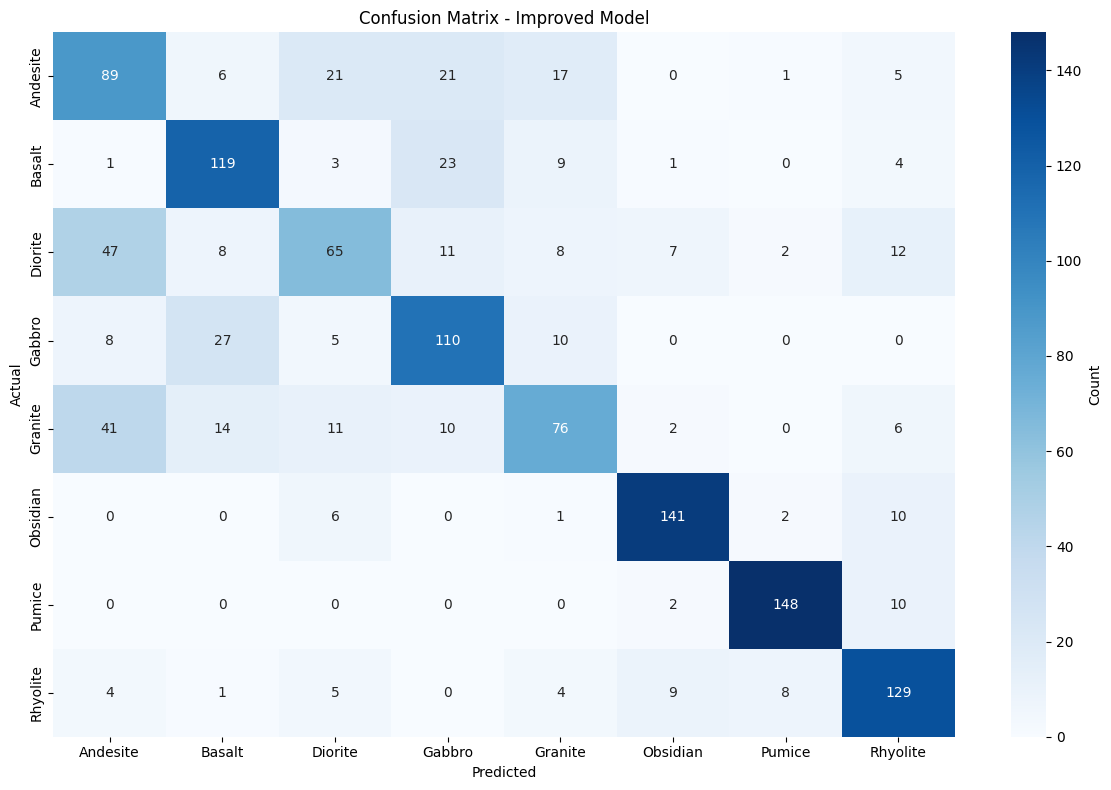

In [8]:
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap='Blues', cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix - Improved Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

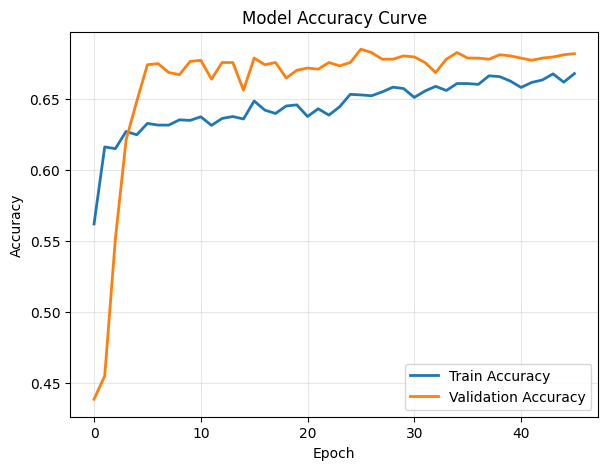

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title("Model Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

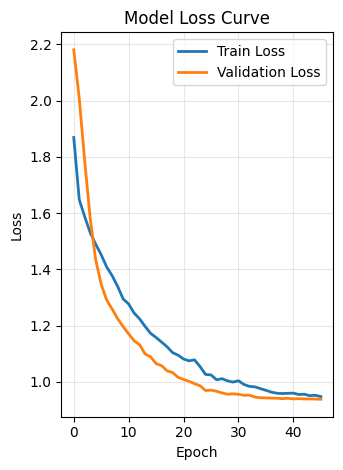

In [10]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Model Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculating feature importance...


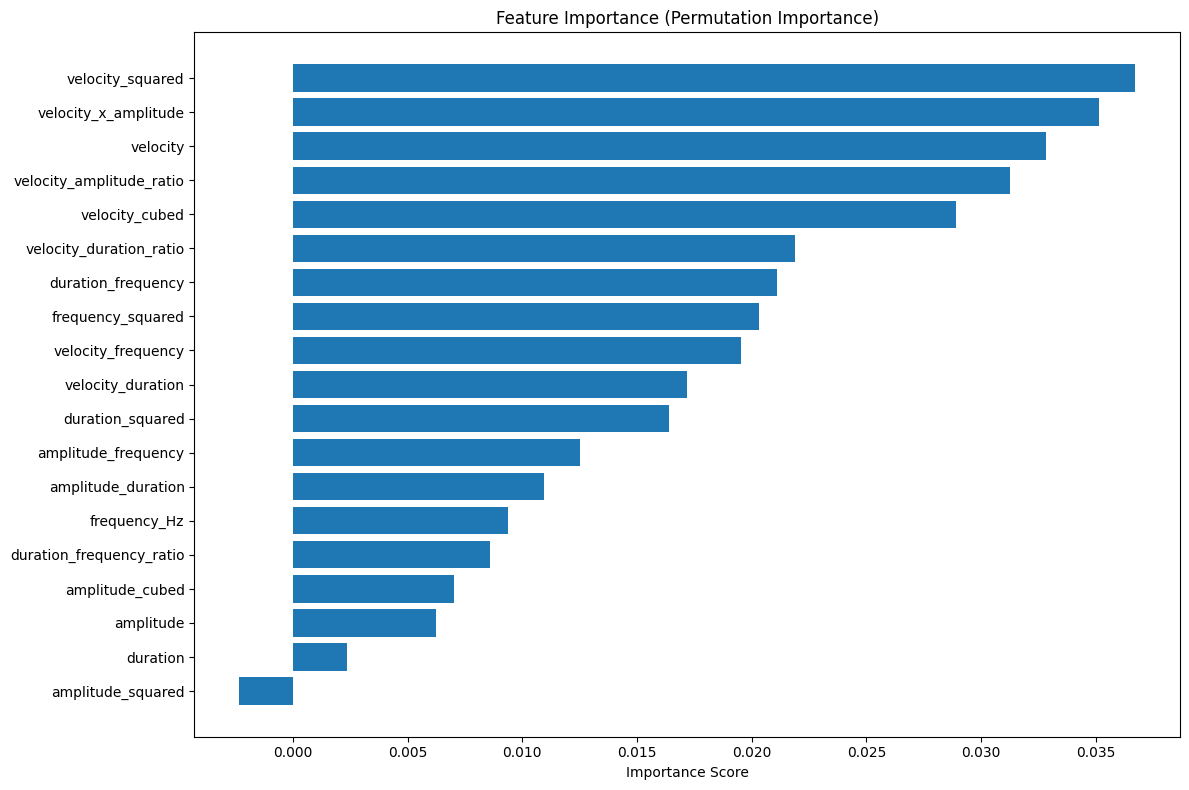

In [11]:
def get_feature_importance(model, X_test, feature_names):
    """Calculate feature importance using permutation importance"""
    baseline_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    importance_scores = []
    for i, feature in enumerate(feature_names):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, i])
        permuted_accuracy = model.evaluate(X_test_permuted, y_test, verbose=0)[1]
        importance = baseline_accuracy - permuted_accuracy
        importance_scores.append(importance)
    return importance_scores
print("\nCalculating feature importance...")
importance_scores = get_feature_importance(model, X_test, feature_cols)
plt.figure(figsize=(12, 8))
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance_scores
}).sort_values('importance', ascending=True)

plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [12]:
joblib.dump(scaler, "igneous_scaler_improved.pkl")
joblib.dump(le, "igneous_label_encoder_improved.pkl")
print(f"\nModel saved as: igneous_model_improved.keras")
print(f"Scaler saved as: igneous_scaler_improved.pkl")
print(f"Label encoder saved as: igneous_label_encoder_improved.pkl")
print(f"Final accuracy: {accuracy:.4f}")



Model saved as: igneous_model_improved.keras
Scaler saved as: igneous_scaler_improved.pkl
Label encoder saved as: igneous_label_encoder_improved.pkl
Final accuracy: 0.6852


In [14]:
import numpy as np
from tensorflow.keras.models import load_model
import joblib
model = load_model("igneous_model_improved.keras")
scaler = joblib.load("igneous_scaler_improved.pkl")
le = joblib.load("igneous_label_encoder_improved.pkl")
def engineer_features(velocity, amplitude, duration, frequency_hz):
    features = [velocity, amplitude, duration, frequency_hz]
    velocity_x_amplitude = velocity * amplitude
    velocity_squared = velocity ** 2
    duration_squared = duration ** 2
    amplitude_duration = amplitude * duration
    velocity_frequency = velocity * frequency_hz
    amplitude_frequency = amplitude * frequency_hz
    duration_frequency = duration * frequency_hz
    velocity_duration = velocity * duration
    amplitude_squared = amplitude ** 2
    frequency_squared = frequency_hz ** 2
    velocity_amplitude_ratio = velocity / amplitude
    duration_frequency_ratio = duration / frequency_hz
    velocity_duration_ratio = velocity / duration
    velocity_cubed = velocity ** 3
    amplitude_cubed = amplitude ** 3
    all_features = [
        velocity, amplitude, duration, frequency_hz,
        velocity_x_amplitude, velocity_squared, duration_squared,
        amplitude_duration, velocity_frequency, amplitude_frequency,
        duration_frequency, velocity_duration, amplitude_squared,
        frequency_squared, velocity_amplitude_ratio, duration_frequency_ratio,
        velocity_duration_ratio, velocity_cubed, amplitude_cubed
    ]
    return np.array(all_features).reshape(1, -1)
def predict_rock_type(velocity, amplitude, duration, frequency_hz, verbose=True):
    sample_features = engineer_features(velocity, amplitude, duration, frequency_hz)
    sample_scaled = scaler.transform(sample_features)
    pred_prob = model.predict(sample_scaled, verbose=0)
    pred_index = np.argmax(pred_prob)
    pred_label = le.inverse_transform([pred_index])[0]
    confidence = np.max(pred_prob)
    if verbose:
        print(f"\n🪨 Input Sample:")
        print(f"   Velocity: {velocity} km/s")
        print(f"   Amplitude: {amplitude}")
        print(f"   Duration: {duration} ms")
        print(f"   Frequency: {frequency_hz} Hz")
        print(f"\n📊 Prediction Results:")
        print(f"   Predicted Rock Type: {pred_label}")
        print(f"   Confidence: {confidence:.3f}")
        print(f"\n📈 All Probabilities:")
        for i, rock_type in enumerate(le.classes_):
            print(f"   {rock_type}: {pred_prob[0][i]:.3f}")
    return pred_label, confidence, pred_prob[0]
if __name__ == "__main__":
    velocity = 5.14
    amplitude = 0.53
    duration = 238
    frequency_hz = 29.75
    rock_type, confidence, probabilities = predict_rock_type(
        velocity, amplitude, duration, frequency_hz
    )
    print(f"\nFinal Result: {rock_type} (Confidence: {confidence:.3f})")


🪨 Input Sample:
   Velocity: 5.14 km/s
   Amplitude: 0.53
   Duration: 238 ms
   Frequency: 29.75 Hz

📊 Prediction Results:
   Predicted Rock Type: Pumice
   Confidence: 0.980

📈 All Probabilities:
   Andesite: 0.000
   Basalt: 0.000
   Diorite: 0.000
   Gabbro: 0.000
   Granite: 0.000
   Obsidian: 0.000
   Pumice: 0.980
   Rhyolite: 0.019

Final Result: Pumice (Confidence: 0.980)
